In [1]:
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (7,5),
    "axes.titlesize": 15,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11
})

DATA_CSV = "../data/black_hole_evolution_tng100.csv"
df = pd.read_csv(DATA_CSV)

FEATURE_ORDER = ["bh_mass","bh_acc","stellar_mass","sfr","halo_mass","vel_disp"]
NAME_MAP = {
    "bh_mass": "Black Hole Mass",
    "bh_acc": "BH Accretion Rate",
    "stellar_mass": "Stellar Mass",
    "sfr": "Star Formation Rate",
    "halo_mass": "Halo Mass",
    "vel_disp": "Velocity Dispersion"
}

df = df.drop_duplicates(subset=["subhalo_id","snapshot"]).reset_index(drop=True)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["bh_mass"])
df.shape


(37412, 8)

In [2]:
n_tracks = df["subhalo_id"].nunique()
snap_counts = df.groupby("subhalo_id")["snapshot"].nunique()
n_snaps = snap_counts.unique()
summary = {
    "tracks": n_tracks,
    "snapshots_min": int(snap_counts.min()),
    "snapshots_max": int(snap_counts.max()),
    "snapshots_median": float(snap_counts.median())
}
summary


{'tracks': 2500,
 'snapshots_min': 14,
 'snapshots_max': 15,
 'snapshots_median': 15.0}

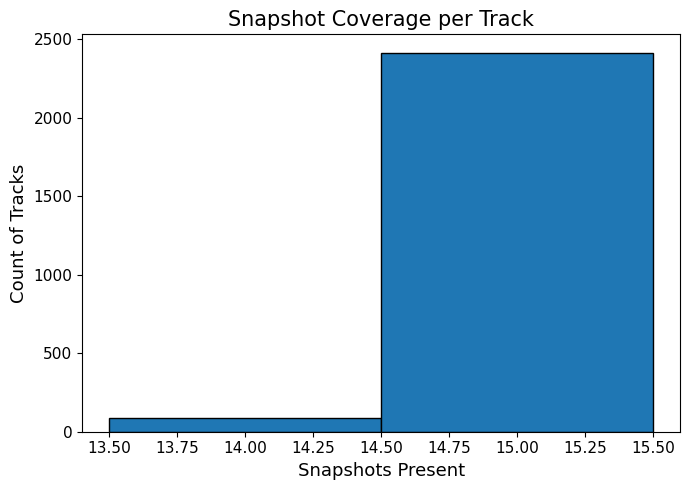

In [3]:
fig, ax = plt.subplots()
ax.hist(snap_counts.values, bins=np.arange(snap_counts.min()-0.5, snap_counts.max()+1.5, 1), edgecolor="black")
ax.set_title("Snapshot Coverage per Track")
ax.set_xlabel("Snapshots Present")
ax.set_ylabel("Count of Tracks")
plt.tight_layout()


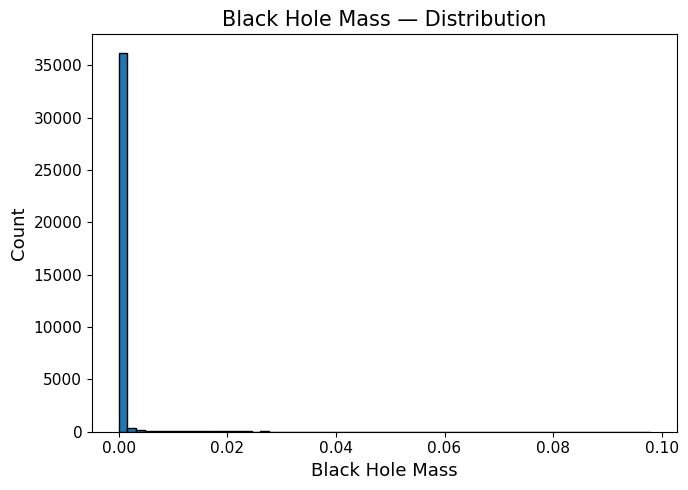

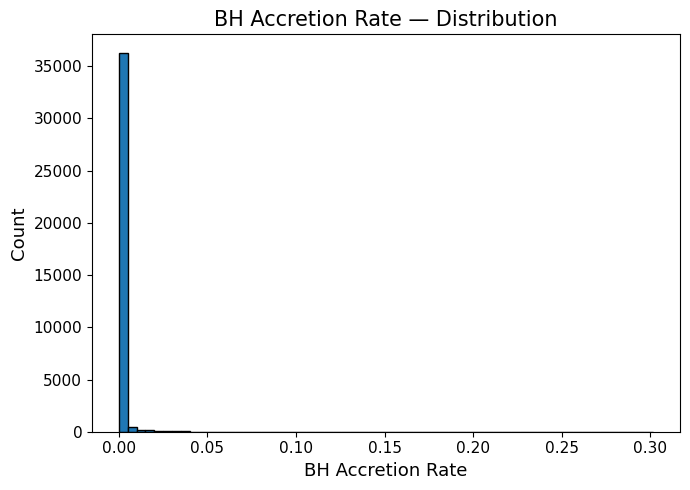

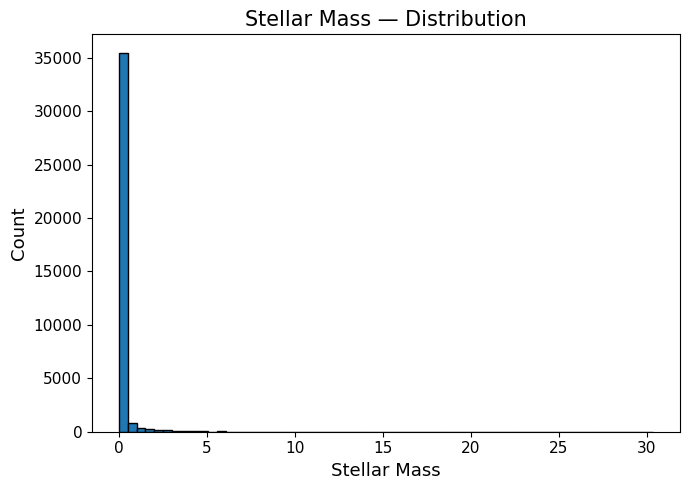

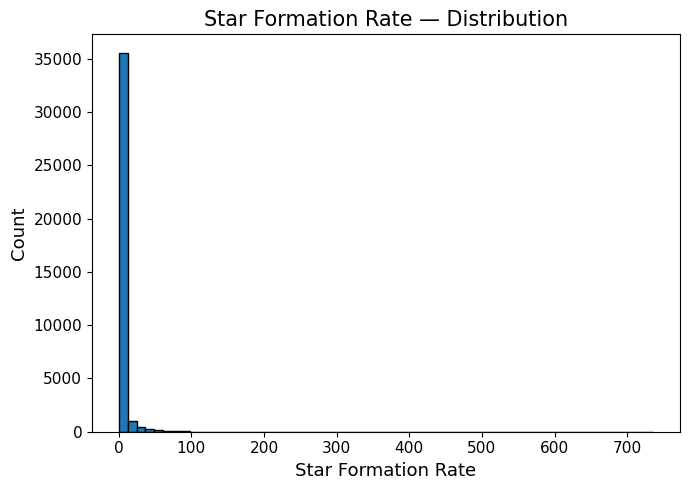

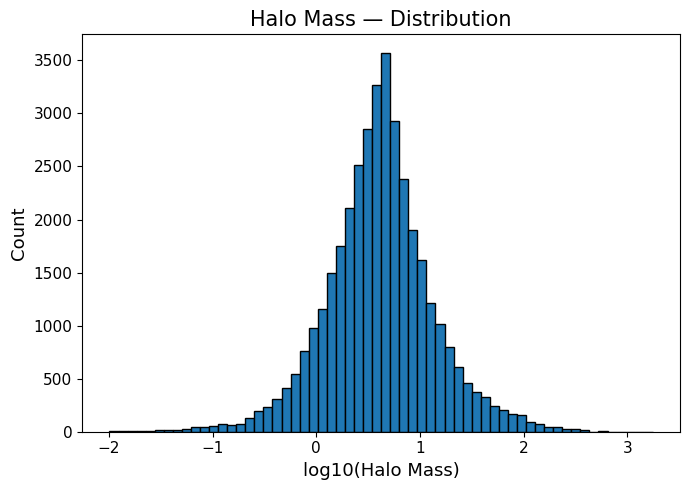

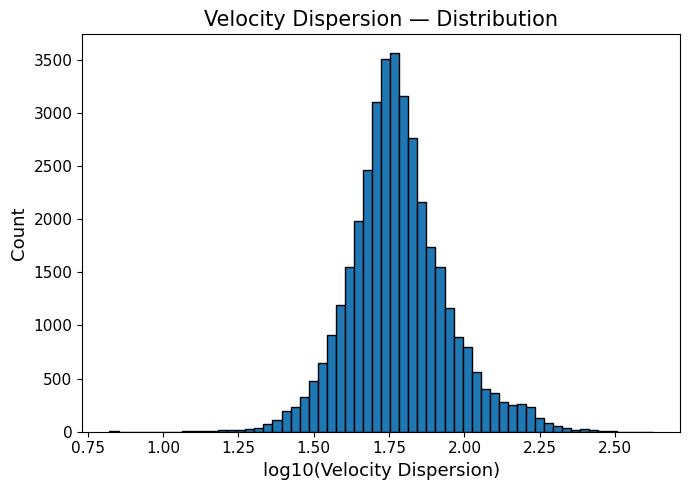

In [4]:
def is_positive(x): 
    return np.all(np.asarray(x) > 0)

for f in FEATURE_ORDER:
    x = df[f].values
    fig, ax = plt.subplots()
    if is_positive(x):
        ax.hist(np.log10(x), bins=60, edgecolor="black")
        ax.set_xlabel(f"log10({NAME_MAP[f]})")
    else:
        ax.hist(x, bins=60, edgecolor="black")
        ax.set_xlabel(NAME_MAP[f])
    ax.set_title(f"{NAME_MAP[f]} — Distribution")
    ax.set_ylabel("Count")
    plt.tight_layout()


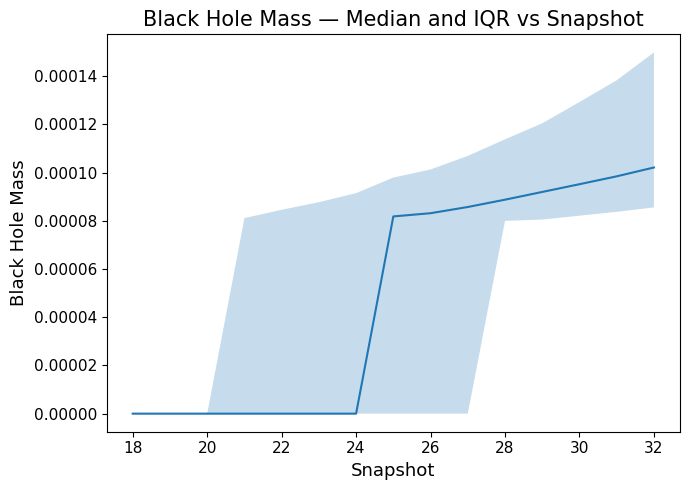

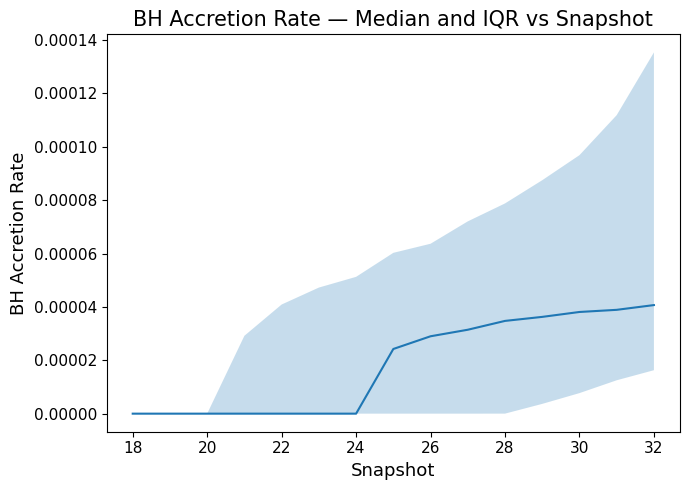

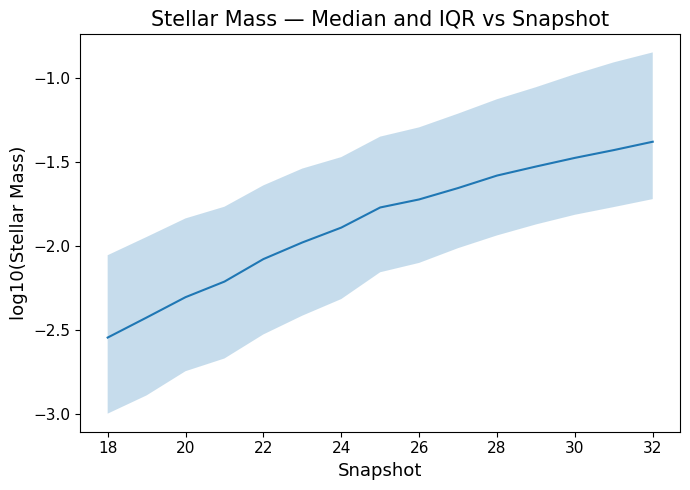

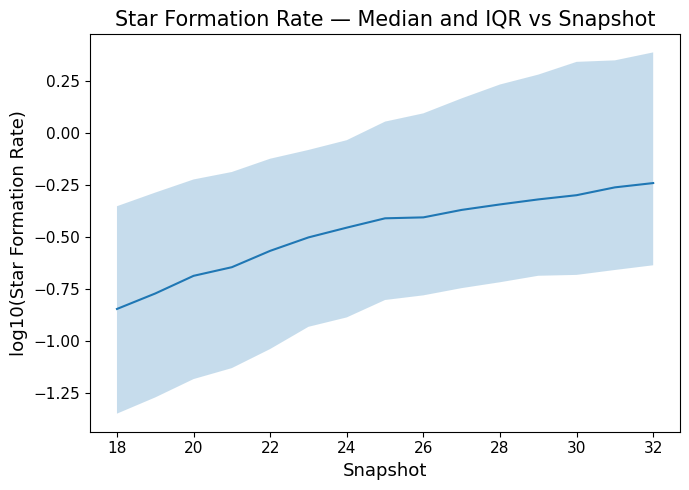

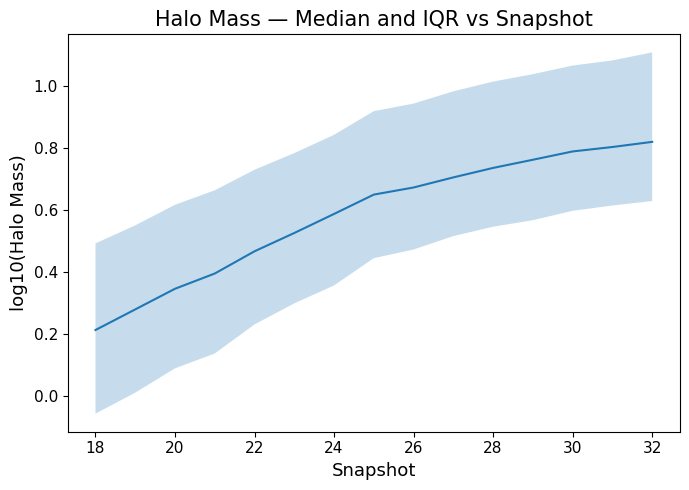

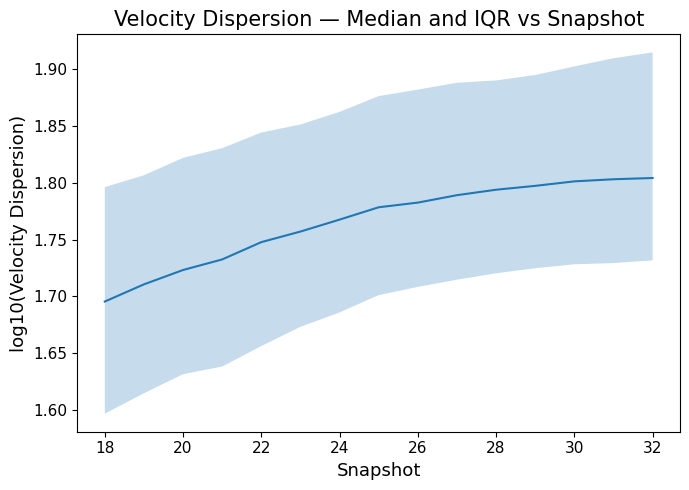

In [5]:
q = df.groupby("snapshot")[FEATURE_ORDER].quantile([0.25,0.5,0.75]).unstack(level=1)
snap_vals = sorted(df["snapshot"].unique())

def plot_median_iqr(feat):
    med = q[(feat,0.5)].reindex(snap_vals).values
    p25 = q[(feat,0.25)].reindex(snap_vals).values
    p75 = q[(feat,0.75)].reindex(snap_vals).values
    fig, ax = plt.subplots()
    if np.all(med > 0):
        ax.plot(snap_vals, np.log10(med))
        ax.fill_between(snap_vals, np.log10(p25), np.log10(p75), alpha=0.25)
        ax.set_ylabel(f"log10({NAME_MAP[feat]})")
    else:
        ax.plot(snap_vals, med)
        ax.fill_between(snap_vals, p25, p75, alpha=0.25)
        ax.set_ylabel(NAME_MAP[feat])
    ax.set_title(f"{NAME_MAP[feat]} — Median and IQR vs Snapshot")
    ax.set_xlabel("Snapshot")
    plt.tight_layout()

for f in FEATURE_ORDER:
    plot_median_iqr(f)


In [6]:
corr = df[FEATURE_ORDER].corr(method="spearman")
corr


,bh_mass,bh_acc,stellar_mass,sfr,halo_mass,vel_disp
bh_mass,1.000000,0.971182,0.885114,0.804466,0.827991,0.782609
bh_acc,0.971182,1.000000,0.866451,0.820292,0.823851,0.794656
stellar_mass,0.885114,0.866451,1.000000,0.933616,0.913968,0.893431
sfr,0.804466,0.820292,0.933616,1.000000,0.893491,0.945542
halo_mass,0.827991,0.823851,0.913968,0.893491,1.000000,0.928788
vel_disp,0.782609,0.794656,0.893431,0.945542,0.928788,1.000000


In [10]:
FIG_DIR = Path("../reports/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)

def safe_log10(arr, eps=1e-12):
    a = np.asarray(arr, dtype=float).copy()
    a[a <= 0] = np.nan if eps is None else eps
    return np.log10(a)


fig, ax = plt.subplots(figsize=(7,5))
ax.hist(
    snap_counts.values,
    bins=np.arange(snap_counts.min()-0.5, snap_counts.max()+1.5, 1),
    edgecolor="black"
)
ax.set_title("Snapshot Coverage per Track")
ax.set_xlabel("Snapshots Present")
ax.set_ylabel("Count of Tracks")
plt.tight_layout()
fig.savefig(FIG_DIR / "coverage_hist.png", dpi=300, bbox_inches="tight")
plt.close(fig)


POSITIVE_ONLY = {"bh_mass","bh_acc","stellar_mass","sfr","halo_mass","vel_disp"}

for feat in FEATURE_ORDER:
    med = q[(feat,0.5)].reindex(snap_vals).values
    p25 = q[(feat,0.25)].reindex(snap_vals).values
    p75 = q[(feat,0.75)].reindex(snap_vals).values

    fig, ax = plt.subplots(figsize=(7,5))
    if feat in POSITIVE_ONLY:
        y_med = safe_log10(med)
        y_p25 = safe_log10(p25)
        y_p75 = safe_log10(p75)
        ax.plot(snap_vals, y_med, lw=2)
        ax.fill_between(snap_vals, y_p25, y_p75, alpha=0.25)
        ax.set_ylabel(f"log10({NAME_MAP[feat]})")
    else:
        ax.plot(snap_vals, med, lw=2)
        ax.fill_between(snap_vals, p25, p75, alpha=0.25)
        ax.set_ylabel(NAME_MAP[feat])

    ax.set_title(f"{NAME_MAP[feat]} — Median and IQR vs Snapshot")
    ax.set_xlabel("Snapshot")
    plt.tight_layout()
    fig.savefig(FIG_DIR / f"evolution_{feat}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

    
fig, ax = plt.subplots(figsize=(6.2,5.8))
im = ax.imshow(corr.values, cmap="viridis", vmin=-1, vmax=1)
ax.set_xticks(range(len(FEATURE_ORDER)))
ax.set_yticks(range(len(FEATURE_ORDER)))
ax.set_xticklabels([NAME_MAP[f] for f in FEATURE_ORDER], rotation=45, ha="right")
ax.set_yticklabels([NAME_MAP[f] for f in FEATURE_ORDER])
for i in range(len(FEATURE_ORDER)):
    for j in range(len(FEATURE_ORDER)):
        val = corr.values[i, j]
        ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                color=("white" if abs(val) > 0.65 else "black"), fontsize=10)
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Spearman ρ")
ax.set_title("Feature Correlations (Spearman)")
plt.tight_layout()
fig.savefig(FIG_DIR / "correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.close(fig)

str(FIG_DIR)


'../reports/figures'